In [4]:
import os
import urllib.request
from urllib.error import HTTPError

import lightning as L
import matplotlib
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint
from torchvision import transforms
from torchvision.datasets import CIFAR10

In [5]:
DATASET_PATH = os.environ.get("PATH_DATASETS", "data/")
# Path to the folder where the pretrained models are saved
# CHECKPOINT_PATH = os.environ.get("PATH_CHECKPOINT", "saved_models/VisionTransformers/")

In [6]:
test_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]),
    ]
)
# For training, we add some augmentation. Networks are too powerful and would overfit.
train_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
        transforms.ToTensor(),
        transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]),
    ]
)

* Downloading CIFAR10 Data

In [7]:
train_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=train_transform, download=True)
val_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=test_transform, download=True)

100%|██████████| 170498071/170498071 [00:11<00:00, 14726436.04it/s]


Extracting data/cifar-10-python.tar.gz to data/
Files already downloaded and verified


In [8]:
L.seed_everything(42)
train_set, _ = torch.utils.data.random_split(train_dataset, [45000, 5000])
L.seed_everything(42)
_, val_set = torch.utils.data.random_split(val_dataset, [45000, 5000])

# Loading the test set
test_set = CIFAR10(root=DATASET_PATH, train=False, transform=test_transform, download=True)

Seed set to 42
Seed set to 42


Files already downloaded and verified


In [9]:
train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = data.DataLoader(val_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4)
test_loader = data.DataLoader(test_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4)

In [10]:
NUM_IMAGES = 4
CIFAR_images = torch.stack([val_set[idx][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(CIFAR_images, nrow=4, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

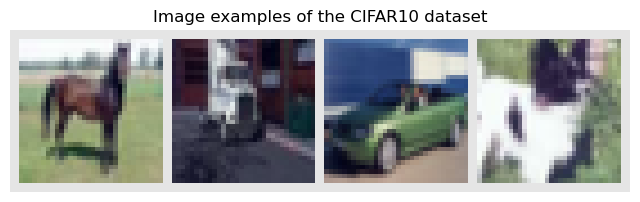

In [11]:
plt.figure(figsize=(8, 8))
plt.title("Image examples of the CIFAR10 dataset")
plt.imshow(img_grid)
plt.axis("off")
plt.show()
plt.close()

In [16]:
def img_to_patch(x, patch_size, flatten_channels = True):
    B,C,H,W = x.shape
    x = x.reshape(B,C,H//patch_size,patch_size,patch_size,W//patch_size,patch_size)
    x = x.permute(0,2,4,1,3,5) # [B,H',W',C,P,P]
    x = x.flatten(1,2) # [B,H'*W',C*P_H*P_W]
    if flatten_channels:
        x = x.flatten(2,4) # [B,H'*W',C*P_H*P_W]
    return x

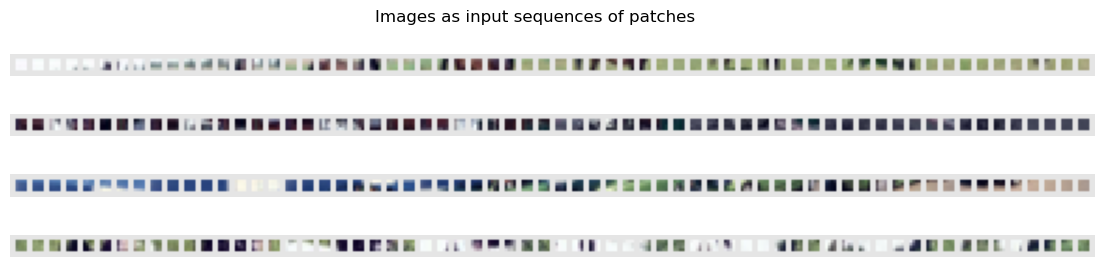

In [17]:
img_patches = img_to_patch(CIFAR_images, patch_size=4, flatten_channels=False)

fig, ax = plt.subplots(CIFAR_images.shape[0], 1, figsize=(14, 3))
fig.suptitle("Images as input sequences of patches")
for i in range(CIFAR_images.shape[0]):
    img_grid = torchvision.utils.make_grid(img_patches[i], nrow=64, normalize=True, pad_value=0.9)
    img_grid = img_grid.permute(1, 2, 0)
    ax[i].imshow(img_grid)
    ax[i].axis("off")
plt.show()
plt.close()


In [18]:
class AttentionBlock(nn.Module):
    def __init__(self, embed_dim, hidden_dim, num_heads, dropout = 0.0):
        super().__init__()
        self.attention = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout)
        )
        
    def forward(self, x):
        inpu_x = self.norm1(x)
        x = x + self.attention(inpu_x, inpu_x, inpu_x)[0] # query, key ,value [0] to make sure we only tak tensors not weights
        x = x + self.mlp(self.norm2(x))
        return x

Vision Transformer:

In [41]:
class VisionTransformer(nn.Module):
    def __init__(self, embed_dim, num_heads, num_layers, hidden_dim, num_classes, patch_size, num_patches,num_channels, dropout = 0.0):
        super().__init__()
        self.patch_size = patch_size
        self.input_layer = nn.Linear(patch_size*patch_size*num_channels, embed_dim)
        self.transformer = nn.Sequential(*[AttentionBlock(embed_dim, hidden_dim, num_heads, dropout) for _ in range(num_layers)])
        self.mlp_head = nn.Sequential(nn.LayerNorm(embed_dim), nn.Linear(embed_dim, num_classes))
        self.dropout = nn.Dropout(dropout)
        self.cls_token = nn.Parameter(torch.randn(1,1,embed_dim))
        self.pos_embedding = nn.Parameter(torch.randn(1,1+num_patches,embed_dim))
        
    def forward(self, x):
        
        x = img_to_patch(x, self.patch_size)
        print(x.shape)
        B,T ,_= x.shape
        
        x = self.input_layer(x)
        cls_tokens = self.cls_token.expand(B,-1,-1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embedding[:, :T+1]
        x = self.dropout(x)
        x = x.transpose(0, 1)
        x = self.transformer(x)

        cls = x[0]
        out = self.mlp_head(cls)
        return out

In [42]:
class ViT(L.LightningModule):
    def __init__(self, model_kwargs, lr):
        super().__init__()
        self.save_hyperparameters()
        self.model = VisionTransformer(**model_kwargs)
        self.example_input_array = next(iter(train_loader))[0]

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr)
        lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100, 150], gamma=0.1)
        return [optimizer], [lr_scheduler]

    def _calculate_loss(self, batch, mode="train"):
        imgs, labels = batch
        preds = self.model(imgs)
        loss = F.cross_entropy(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        self.log("%s_loss" % mode, loss)
        self.log("%s_acc" % mode, acc)
        return loss

    def training_step(self, batch, batch_idx):
        loss = self._calculate_loss(batch, mode="train")
        return loss

    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="val")

    def test_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="test")

In [43]:
def train_model(**kwargs):
    trainer = L.Trainer(
        accelerator="auto",
        devices=2,
        max_epochs=180,
        callbacks=[
            ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),
            LearningRateMonitor("epoch"),
        ],
    )
    trainer.logger._log_graph = True  # If True, we plot the computation graph in tensorboard
    trainer.logger._default_hp_metric = None  # Optional logging argument that we don't need
    
    L.seed_everything(42)  # To be reproducible
    model = ViT(**kwargs)
    trainer.fit(model, train_loader, val_loader)
    # Load best checkpoint after training
    model = ViT.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    # Test best model on validation and test set
    val_result = trainer.test(model, dataloaders=val_loader, verbose=False)
    test_result = trainer.test(model, dataloaders=test_loader, verbose=False)
    result = {"test": test_result[0]["test_acc"], "val": val_result[0]["test_acc"]}

    return model, result

In [44]:
model, results = train_model(
    model_kwargs={
        "embed_dim": 256,
        "hidden_dim": 512,
        "num_heads": 8,
        "num_layers": 6,
        "patch_size": 4,
        "num_channels": 3,
        "num_patches": 64,
        "num_classes": 10,
        "dropout": 0.2,
    },
    lr=3e-4,
)
print("ViT results", results)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Seed set to 42
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name  | Type              | Params | In sizes         | Out sizes
---------------------------------------------------------------------------
0 | model | VisionTransformer | 3.2 M  | [128, 3, 32, 32] | [128, 10]
---------------------------------------------------------------------------
3.2 M     Trainable params
0         Non-trainable params
3.2 M     Total params
12.781    Total estimated model params size (MB)


torch.Size([128, 64, 48])
Epoch 0: 100%|██████████| 351/351 [00:08<00:00, 40.17it/s, v_num=2]torch.Size([128, 64, 48])
torch.Size([128, 64, 48])
torch.Size([128, 64, 48])
torch.Size([128, 64, 48])
torch.Size([128, 64, 48])
torch.Size([128, 64, 48])
torch.Size([128, 64, 48])
torch.Size([128, 64, 48])
torch.Size([128, 64, 48])
torch.Size([128, 64, 48])
torch.Size([128, 64, 48])
torch.Size([128, 64, 48])
torch.Size([128, 64, 48])
torch.Size([128, 64, 48])
torch.Size([128, 64, 48])
torch.Size([128, 64, 48])
torch.Size([128, 64, 48])
torch.Size([128, 64, 48])
torch.Size([128, 64, 48])
torch.Size([128, 64, 48])
torch.Size([128, 64, 48])
torch.Size([128, 64, 48])
torch.Size([128, 64, 48])
torch.Size([128, 64, 48])
torch.Size([128, 64, 48])
torch.Size([128, 64, 48])
torch.Size([128, 64, 48])
torch.Size([128, 64, 48])
torch.Size([128, 64, 48])
torch.Size([128, 64, 48])
torch.Size([128, 64, 48])
torch.Size([128, 64, 48])
torch.Size([128, 64, 48])
torch.Size([128, 64, 48])
torch.Size([128, 64, 48